In [2]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import classification_report , confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from health.utils import load_training_data, column_encoder,clean_str_data, EXEC_MODE
from sklearn.neural_network import MLPClassifier
from joblib import dump  
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import json
import hashlib

from datetime import datetime

df = load_training_data()
df = df.reset_index(drop=True)
df.set_index(['id'])


col_len = len(df.columns.to_list())
X = df.iloc[:,1:col_len -1]
Y = df.iloc[:,col_len-1:]



2024-11-22 16:50:16.516 | INFO     | health.config:<module>:11 - PROJ_ROOT path is: /Users/ceegees/workspace/iisc-learning/are-you-depressed


In [3]:

# Transform the data

def create_report(model_name,model, params,X,Y):

    json_str = json.dumps(params)
    md5 = hashlib.md5(json_str.encode('utf-8')).hexdigest()
    param_file = f"../models/params/params-{model_name}-{md5}.json"
    if os.path.isfile(param_file):
        print("re running running as report is already geenrated")
        # return

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=16)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred,output_dict=True)
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()

    mx  = confusion_matrix(y_test, y_pred)
    total = len(X_test)

 
    model_file = f'../models/{model_name}-{md5}.joblib'
    run_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    

    registry_file = os.path.join(f'../reports/{EXEC_MODE}/model_report.csv')
    if not os.path.exists(registry_file):
        registry_df = pd.DataFrame(columns=["run_date",  "model_name",
        "accuracy",
        "tn", 'tp', 'fn', 'fp',
        "model_file", 
        
        #  "precision","recall","f1_score"
        ])
    else:
        registry_df = pd.read_csv(registry_file)
        
    new_entry = {
        "run_date": run_date,
        "model_name":model_name,
        "accuracy":round(report['accuracy']*100,2),
        "tn": round(tn*100/total,2),
        "tp": round(tp*100/total,2),
        "fn": round(fn*100/total,2),
        "fp": round(tp*100/total,2),
        "model_path": model_file,
        "param_path": param_file, 
    }
    registry_df = pd.concat([registry_df, pd.DataFrame([new_entry])], ignore_index=True)
    registry_df.to_csv(registry_file, index=False)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = mx, display_labels = [0, 1])
    cm_display.plot()  

    r2 = classification_report(y_test, y_pred)
    print(r2)

    with open(param_file, "w") as paramfile:
        json.dump(params, paramfile)
    dump(model,model_file)

    


re running running as report is already geenrated


/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     28826
         1.0       0.76      0.63      0.69      6349

    accuracy                           0.90     35175
   macro avg       0.84      0.79      0.81     35175
weighted avg       0.89      0.90      0.89     35175



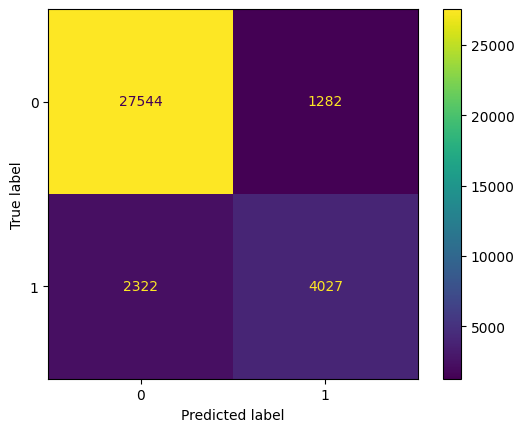

In [4]:

# instantiate the model (using the default parameters)
params = {'random_state':10}
model = LogisticRegression(**params)
pipeline = Pipeline(steps=[('encoder', column_encoder), ('model', model)])
create_report(f"logistic-{EXEC_MODE}",pipeline,params,X,Y)

re running running as report is already geenrated


/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     28826
         1.0       0.76      0.63      0.69      6349

    accuracy                           0.90     35175
   macro avg       0.84      0.79      0.81     35175
weighted avg       0.89      0.90      0.89     35175



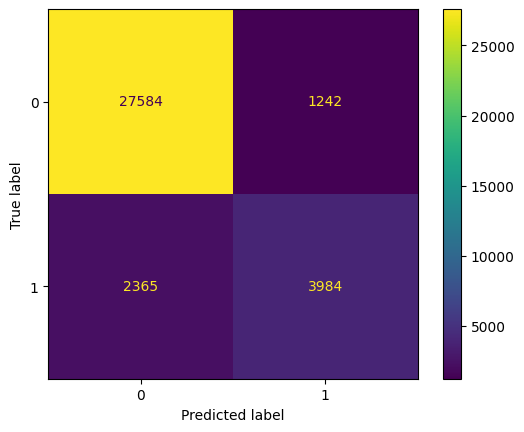

In [5]:


params = {
    "solver":'adam', #lbfgs , sgd
    "alpha":0.24,
    "hidden_layer_sizes":(3, 6),
    "random_state":2,
    "max_iter":25,
    "learning_rate":'constant',
    "activation":"relu",
    "tol":1e-4
}
clf = MLPClassifier(**params)
scaler = StandardScaler()
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001],  # L2 regularization parameter
}


# ('scaler',scaler),
pipeline2 = Pipeline(steps=[ ('encoder', column_encoder) ,('mlp', clf)])
create_report(f'mlpclf-{EXEC_MODE}',pipeline2,params,X,Y)
 


In [7]:

param_grid = {
    # 'log__penalty':['l2','l1','elasticnet'],
    'log__tol':[0.0001],
    'log__random_state':[10],
    # 'log__class_weight':['balanced','None'], 
    # 'log__solver':['lbfgs'], # 'newton-cholesky', 'sag', 'saga'],
    # 'log__max_iter': [100], 
}
log = LogisticRegression()

pipeline3 = Pipeline(steps=[('encoder', column_encoder) ,('log', log)]) 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=16)
grid_s1 = GridSearchCV(pipeline3, param_grid, cv=3)
grid_s1.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_s1.best_params_)
print("Best Cross-Validation Score:", grid_s1.best_score_)

  


/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'log__random_state': 10, 'log__tol': 0.0001}
Best Cross-Validation Score: 0.8973513385453683


/Users/ceegees/workspace/iisc-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
 
param_grid = {
    'mlp__hidden_layer_sizes': [(10,), (20,)], # (20, 10)],
    'mlp__activation': ['relu'], # 'tanh'],
    'mlp__solver': ['adam'], # 'sgd'],
    'mlp__alpha': [0.0001, 0.001],  # L2 regularization parameter
}

pipeline4 = Pipeline(steps=[('encoder', column_encoder) ,('mlp', clf)]) 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=16)
grid_search = GridSearchCV(pipeline4, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
